In [1]:
import json, os
import torch
import bertviz, uuid
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from collections import Counter
from transformers import LlamaForCausalLM, LlamaTokenizer
from IPython.core.display import display, HTML, Javascript
from bertviz.util import format_special_chars, format_attention, num_layers, num_heads
LAYER_NUM = 32
HEAD_NUM = 32
HEAD_DIM = 128
HIDDEN_DIM = HEAD_NUM * HEAD_DIM
torch.set_default_device("cuda")

/tmp/5197255.1.nvidiagpu.q/ipykernel_24877/2592505748.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [2]:
def transfer_output(model_output):
    all_pos_layer_input = []
    all_pos_attn_output = []
    all_pos_residual_output = []
    all_pos_ffn_output = []
    all_pos_layer_output = []
    all_last_attn_subvalues = []
    all_pos_coefficient_scores = []
    all_attn_scores = []
    for layer_i in range(LAYER_NUM):
        cur_layer_input = model_output[layer_i][0]
        cur_attn_output = model_output[layer_i][1]
        cur_residual_output = model_output[layer_i][2]
        cur_ffn_output = model_output[layer_i][3]
        cur_layer_output = model_output[layer_i][4]
        cur_last_attn_subvalues = model_output[layer_i][5]
        cur_coefficient_scores = model_output[layer_i][6]
        cur_attn_weights = model_output[layer_i][7]
        all_pos_layer_input.append(cur_layer_input[0].tolist())
        all_pos_attn_output.append(cur_attn_output[0].tolist())
        all_pos_residual_output.append(cur_residual_output[0].tolist())
        all_pos_ffn_output.append(cur_ffn_output[0].tolist())
        all_pos_layer_output.append(cur_layer_output[0].tolist())
        all_last_attn_subvalues.append(cur_last_attn_subvalues[0].tolist())
        all_pos_coefficient_scores.append(cur_coefficient_scores[0].tolist())
        all_attn_scores.append(cur_attn_weights)
    return all_pos_layer_input, all_pos_attn_output, all_pos_residual_output, all_pos_ffn_output, \
           all_pos_layer_output, all_last_attn_subvalues, all_pos_coefficient_scores, all_attn_scores
def get_fc2_params(model, layer_num):
    return model.model.layers[layer_num].mlp.down_proj.weight.data
def get_bsvalues(vector, model, final_var):
    vector = vector * torch.rsqrt(final_var + 1e-6)
    vector_rmsn = vector * model.model.norm.weight.data
    vector_bsvalues = model.lm_head(vector_rmsn).data
    return vector_bsvalues
    return vector_bsvalues
def get_prob(vector):
    prob = torch.nn.Softmax(-1)(vector)
    return prob
def transfer_l(l):
    new_x, new_y = [], []
    for x in l:
        new_x.append(x[0])
        new_y.append(x[1])
    return new_x, new_y
def plt_bar(x, y, yname="log increase"):
    x_major_locator=MultipleLocator(1)
    plt.figure(figsize=(8, 3))
    ax=plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    plt_x = [a/2 for a in x]
    plt.xlim(-0.5, plt_x[-1]+0.49)
    x_attn, y_attn, x_ffn, y_ffn = [], [], [], []
    for i in range(len(x)):
        if i%2 == 0:
            x_attn.append(x[i]/2)
            y_attn.append(y[i])
        else:
            x_ffn.append(x[i]/2)
            y_ffn.append(y[i])
    plt.bar(x_attn, y_attn, color="darksalmon", label="attention layers")
    plt.bar(x_ffn, y_ffn, color="lightseagreen", label="FFN layers")
    plt.xlabel("layer")
    plt.ylabel(yname)
    plt.legend()
    plt.show()
def plt_heatmap(data):
    xLabel = range(len(data[0]))
    yLabel = range(len(data))
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    im = ax.imshow(data, cmap=plt.cm.hot_r)
    #plt.colorbar(im)
    plt.title("attn head log increase heatmap")
    plt.show()

In [3]:
#please replace your own dir saving llama-7b model.
#if you haven't downloaded it, you can try "huggyllama/llama-7b" to automatically download it from huggingface.
modelname = "../../scratch/save_models/llama-7b" 
tokenizer = LlamaTokenizer.from_pretrained(modelname)
model = LlamaForCausalLM.from_pretrained(modelname)
model.eval()
model.cuda()

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
 

In [4]:
#compute the final prediction of the input
test_sentence = "Tim Duncan plays the sport of"
indexed_tokens = tokenizer.encode(test_sentence)
tokens = [tokenizer.decode(x) for x in indexed_tokens]
tokens_tensor = torch.tensor([indexed_tokens])
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]
predicted_top10 = torch.argsort(predictions[0][-1], descending=True)[:10]
predicted_text = [tokenizer.decode(x) for x in predicted_top10]
print(test_sentence, "=>", predicted_text)
all_pos_layer_input, all_pos_attn_output, all_pos_residual_output, all_pos_ffn_output, all_pos_layer_output, \
all_last_attn_subvalues, all_pos_coefficient_scores, all_attn_scores = transfer_output(outputs[1])
final_var = torch.tensor(all_pos_layer_output[-1][-1]).pow(2).mean(-1, keepdim=True)
pos_len = len(tokens)
print(tokens)

Tim Duncan plays the sport of => ['basketball', 'his', 'life', 'Basketball', 'golf', 'the', 'k', 's', 'a', 'tennis']
['<s>', 'Tim', 'Dun', 'can', 'plays', 'the', 'sport', 'of']


In [5]:
predict_index = predicted_top10[0].item()
print(predict_index, tokenizer.decode(predict_index))

20305 basketball


attn sum:  6.077 ffn sum:  3.9290000000000003
attn:  [('23', 1.201), ('21', 0.919), ('18', 0.728), ('31', 0.506), ('15', 0.489), ('14', 0.35), ('20', 0.304), ('17', 0.303), ('19', 0.229), ('30', 0.17), ('25', 0.157), ('11', 0.112), ('27', 0.112), ('28', 0.106), ('10', 0.088), ('29', 0.071), ('4', 0.062), ('24', 0.057), ('2', 0.054), ('16', 0.034), ('12', 0.031), ('22', 0.031), ('8', 0.02), ('5', 0.019), ('0', 0.016), ('1', 0.003), ('3', 0.0), ('9', 0.0), ('6', 0.0), ('7', -0.002), ('13', -0.013), ('26', -0.08)]
ffn:  [('31', 1.315), ('20', 1.109), ('22', 1.017), ('21', 0.902), ('19', 0.406), ('23', 0.399), ('16', 0.262), ('25', 0.25), ('17', 0.224), ('18', 0.14), ('15', 0.116), ('13', 0.073), ('6', 0.062), ('14', 0.052), ('8', 0.046), ('27', 0.034), ('0', 0.012), ('2', 0.01), ('1', 0.005), ('28', 0.002), ('10', -0.026), ('29', -0.028), ('5', -0.031), ('7', -0.035), ('3', -0.036), ('9', -0.037), ('12', -0.05), ('4', -0.055), ('11', -0.078), ('24', -0.23), ('26', -0.576), ('30', -1.325)]

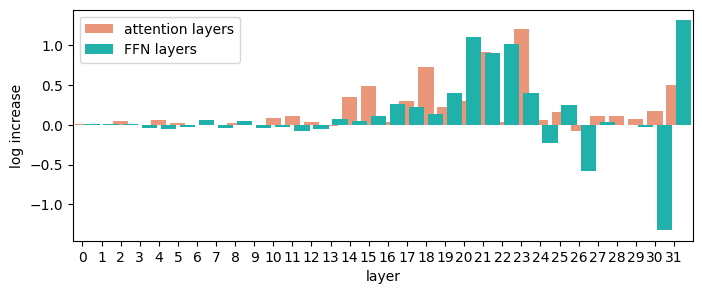

In [6]:
#layer-level increase (value layers)
all_attn_log_increase = []
for layer_i in range(LAYER_NUM):
    cur_attn_vector = torch.tensor(all_pos_attn_output[layer_i][-1])
    cur_layer_input = torch.tensor(all_pos_layer_input[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_layer_input, model, final_var))[predict_index])
    cur_attn_vector_plus = cur_attn_vector + cur_layer_input
    cur_attn_vector_bsvalues = get_bsvalues(cur_attn_vector_plus, model, final_var)
    cur_attn_vector_probs = get_prob(cur_attn_vector_bsvalues)
    cur_attn_vector_probs = cur_attn_vector_probs[predict_index]
    cur_attn_vector_probs_log = torch.log(cur_attn_vector_probs)
    cur_attn_vector_probs_log_increase = cur_attn_vector_probs_log - origin_prob_log
    all_attn_log_increase.append(cur_attn_vector_probs_log_increase.item())
all_ffn_log_increase = []
for layer_i in range(LAYER_NUM):
    cur_ffn_vector = torch.tensor(all_pos_ffn_output[layer_i][-1])
    cur_residual = torch.tensor(all_pos_residual_output[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_residual, model, final_var))[predict_index])
    cur_ffn_vector_plus = cur_ffn_vector + cur_residual
    cur_ffn_vector_bsvalues = get_bsvalues(cur_ffn_vector_plus, model, final_var)
    cur_ffn_vector_probs = get_prob(cur_ffn_vector_bsvalues)
    cur_ffn_vector_probs = cur_ffn_vector_probs[predict_index]
    cur_ffn_vector_probs_log = torch.log(cur_ffn_vector_probs)
    cur_ffn_vector_probs_log_increase = cur_ffn_vector_probs_log - origin_prob_log
    all_ffn_log_increase.append(cur_ffn_vector_probs_log_increase.tolist())
attn_list, ffn_list = [], []
for layer_i in range(LAYER_NUM):
    attn_list.append([str(layer_i), all_attn_log_increase[layer_i]])
    ffn_list.append([str(layer_i), all_ffn_log_increase[layer_i]])
attn_list_sort = sorted(attn_list, key=lambda x: x[-1])[::-1]#[:10]
ffn_list_sort = sorted(ffn_list, key=lambda x: x[-1])[::-1]#[:10]
attn_increase_compute, ffn_increase_compute = [], []
for indx, increase in attn_list_sort:
    attn_increase_compute.append((indx, round(increase, 3)))
for indx, increase in ffn_list_sort:
    ffn_increase_compute.append((indx, round(increase, 3)))
print("attn sum: ", sum([x[1] for x in attn_increase_compute]), 
      "ffn sum: ", sum([x[1] for x in ffn_increase_compute]))
print("attn: ", attn_increase_compute)
print("ffn: ", ffn_increase_compute)
all_increases_draw = []
for i in range(len(attn_list)):
    all_increases_draw.append(attn_list[i][1])
    all_increases_draw.append(ffn_list[i][1])    
plt_bar(range(len(all_increases_draw)), all_increases_draw)

[['23_12', 0.9781], ['21_0', 0.8648], ['15_15', 0.3579], ['31_25', 0.3314], ['18_23', 0.3287], ['20_12', 0.2692], ['19_31', 0.229], ['14_3', 0.2102], ['17_27', 0.1973], ['18_7', 0.1846], ['23_23', 0.1331], ['17_10', 0.1233], ['25_25', 0.1211], ['30_4', 0.1186], ['18_28', 0.1049], ['16_23', 0.0971], ['22_13', 0.0875], ['15_6', 0.0826], ['28_15', 0.0764], ['14_8', 0.0704], ['19_26', 0.069], ['11_17', 0.0672], ['18_1', 0.0628], ['16_20', 0.061], ['16_5', 0.059], ['12_15', 0.0569], ['27_20', 0.0562], ['20_22', 0.0553], ['29_4', 0.05], ['17_19', 0.0498]]


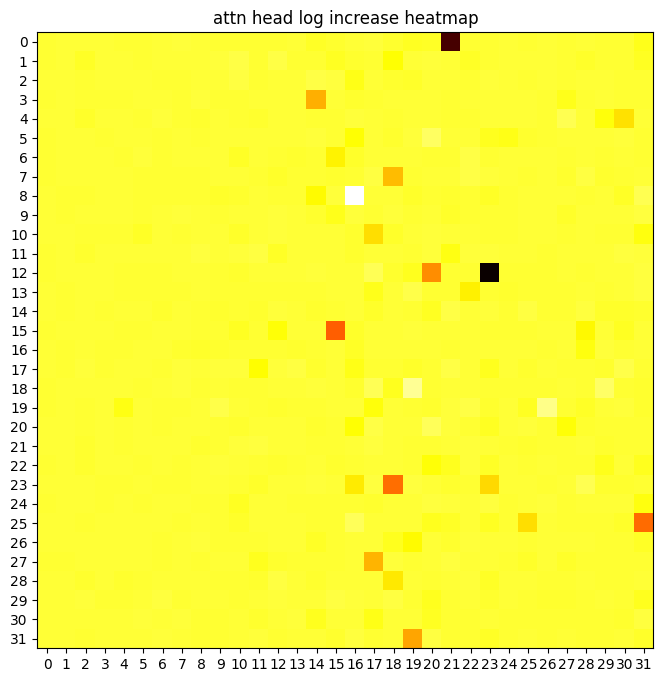

In [7]:
#head-level increase (value heads)
all_head_increase = []
for test_layer in range(LAYER_NUM):
    cur_layer_input = torch.tensor(all_pos_layer_input[test_layer])
    cur_v_heads = torch.tensor(all_last_attn_subvalues[test_layer])
    cur_attn_o_split = model.model.layers[test_layer].self_attn.o_proj.weight.data.T.view(HEAD_NUM, HEAD_DIM, -1)
    cur_attn_subvalues_headrecompute = torch.bmm(cur_v_heads, cur_attn_o_split).permute(1, 0, 2)
    cur_attn_subvalues_head_sum = torch.sum(cur_attn_subvalues_headrecompute, 0)
    cur_layer_input_last = cur_layer_input[-1]
    origin_prob = torch.log(get_prob(get_bsvalues(cur_layer_input_last, model, final_var))[predict_index])
    cur_attn_subvalues_head_plus = cur_attn_subvalues_head_sum + cur_layer_input_last
    cur_attn_plus_probs = torch.log(get_prob(get_bsvalues(
            cur_attn_subvalues_head_plus, model, final_var))[:, predict_index])
    cur_attn_plus_probs_increase = cur_attn_plus_probs - origin_prob
    for i in range(len(cur_attn_plus_probs_increase)):
        all_head_increase.append([str(test_layer)+"_"+str(i), round(cur_attn_plus_probs_increase[i].item(), 4)])

all_head_increase_sort = sorted(all_head_increase, key=lambda x:x[-1])[::-1]
print(all_head_increase_sort[:30])
all_head_increase_list = [x[1] for x in all_head_increase]
all_head_increase_list_split = torch.tensor(all_head_increase_list).view((LAYER_NUM, HEAD_NUM)).permute((1,0)).tolist()
plt_heatmap(all_head_increase_list_split)

In [8]:
#pos-level increase in a specified head
#please see this paper for details: https://arxiv.org/abs/2402.02872
test_layer, test_head = 15, 15
cur_layer_input = torch.tensor(all_pos_layer_input[test_layer])
cur_v_heads = torch.tensor(all_last_attn_subvalues[test_layer])
cur_attn_o_split = model.model.layers[test_layer].self_attn.o_proj.weight.data.T.view(HEAD_NUM, HEAD_DIM, -1)
cur_attn_subvalues_headrecompute = torch.bmm(cur_v_heads, cur_attn_o_split).permute(1, 0, 2)
cur_attn_subvalues_headrecompute_curhead = cur_attn_subvalues_headrecompute[:, test_head, :]
cur_layer_input_last = cur_layer_input[-1]
origin_prob = torch.log(get_prob(get_bsvalues(cur_layer_input_last, model, final_var))[predict_index])
cur_attn_subvalues_headrecompute_curhead_plus = cur_attn_subvalues_headrecompute_curhead + cur_layer_input_last
cur_attn_subvalues_headrecompute_curhead_plus_probs = torch.log(get_prob(get_bsvalues(
    cur_attn_subvalues_headrecompute_curhead_plus, model, final_var))[:, predict_index])
cur_attn_subvalues_headrecompute_increase = cur_attn_subvalues_headrecompute_curhead_plus_probs - origin_prob
cur_attn_subvalues_headrecompute_increase_zip = list(zip(range(len(cur_attn_subvalues_headrecompute_increase)), 
    tokens, cur_attn_subvalues_headrecompute_increase.tolist()))
cur_attn_subvalues_headrecompute_increase_zip_sort = sorted(cur_attn_subvalues_headrecompute_increase_zip,
    key=lambda x:x[-1])[::-1]
cur_layer_input_bsvalues = get_bsvalues(cur_layer_input, model, final_var)
cur_layer_input_bsvalues_sort = torch.argsort(cur_layer_input_bsvalues, descending=True)
cur_attn_subvalues_headrecompute_curhead_bsvalues = get_bsvalues(
    cur_attn_subvalues_headrecompute_curhead, model, final_var)
cur_attn_subvalues_headrecompute_curhead_bsvalues_sort = torch.argsort(
    cur_attn_subvalues_headrecompute_curhead_bsvalues, descending=True)
key_input = cur_layer_input.clone()
key_input -= torch.tensor(all_pos_layer_input[0])
for layer_i in range(test_layer):
    key_input -= torch.tensor(all_pos_ffn_output[layer_i])
key_input_bsvalues = get_bsvalues(key_input, model, final_var)
key_input_bsvalues_sort = torch.argsort(key_input_bsvalues, descending=True)
print(list(zip(range(len(tokens)), tokens)))
for pos, word, increase in cur_attn_subvalues_headrecompute_increase_zip_sort:
    print("\n", pos, word, "increase: ", round(increase, 4), "attn: ", round(
        all_attn_scores[test_layer][0][test_head][-1][pos].item(), 4))
    print("layer input: ", [tokenizer.decode(x) for x in cur_layer_input_bsvalues_sort[pos][:20]])
    print("key: ", [tokenizer.decode(x) for x in key_input_bsvalues_sort[pos][:20]])
    print("value: ", [tokenizer.decode(x) for x in cur_attn_subvalues_headrecompute_curhead_bsvalues_sort[pos][:10]])

[(0, '<s>'), (1, 'Tim'), (2, 'Dun'), (3, 'can'), (4, 'plays'), (5, 'the'), (6, 'sport'), (7, 'of')]

 3 can increase:  0.2512 attn:  0.3677
layer input:  ["'", ':', '’', 'hom', 'pa', 'Van', '', 'is', 'lim', '<?', 'and', '<0x09>', '»', 'season', '|', '?', 'super', '.', '<0x0A>', 'vs']
key:  ['<0x0A>', '|', '...', '-', ':', '<0x09>', '-', '', "'", 'h', '?', '=>', 'his', 'con', '.', '::', 'vs', '?:', '..', ':']
value:  ['NBA', 'basketball', 'Basketball', 'asketball', 'basket', 'courts', 'Jazz', 'court', 'court', 'jazz']

 2 Dun increase:  0.0478 attn:  0.1298
layer input:  ['ning', 'ne', 'ais', 'cu', 'ny', 'Glo', 'живе', 'ulator', 'catch', 'cv', 'fro', 'augh', 'Sug', 'Lord', 'assault', 'Selbst', 'mock', 'ison', 'son', 'ick']
key:  ['vis', '-', '...', '<0x09>', "'", '-', 'vs', 'of', 'i', 'cas', '<0x0A>', 'I', 'for', '\u200e', '>', 'Tim', '…', '!', 'is', 'Arc']
value:  ['basketball', 'NBA', 'Basketball', 'asketball', 'hockey', 'Hockey', 'Sports', 'sports', 'horse', 'horses']

 4 plays incre

In [9]:
#visualize the information transform by attention weights
n_heads = num_heads(all_attn_scores)
attn_data = []
include_layers = list(range(num_layers(all_attn_scores)))
include_heads = list(range(n_heads))
attention1 = format_attention(all_attn_scores, None)
attn_data.append({'name': None, 'attn': attention1.tolist(), 'left_text': tokens, 'right_text': tokens})
vis_id = 'bertviz-%s'%(uuid.uuid4().hex)
select_html = ""
vis_html = f"""      
        <div id="{vis_id}" style="font-family:'Helvetica Neue', Helvetica, Arial, sans-serif;">
            <span style="user-select:none">
                Layer: <select id="layer"></select>
                {select_html}
            </span>
            <div id='vis'></div>
        </div>
    """
if True:
    for d in attn_data:
        attn_seq_len_left = len(d['attn'][0][0]) #16
        attn_seq_len_right = len(d['attn'][0][0][0]) #16
        d['left_text'] = format_special_chars(d['left_text'])
        d['right_text'] = format_special_chars(d['right_text'])
params = {
        'attention': attn_data,
        'default_filter': "0",
        'root_div_id': vis_id,
        'layer': None,
        'heads': None,
        'include_layers': include_layers
        }
display(HTML('<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>'))
display(HTML(vis_html))
__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(bertviz.__file__)))
vis_js = open(os.path.join(__location__, 'head_view.js')).read().replace("PYTHON_PARAMS", json.dumps(params))
display(Javascript(vis_js))

<IPython.core.display.Javascript object>

In [10]:
#FFN neuron increase (value FFN neuron)
all_ffn_subvalues = []
for layer_i in range(LAYER_NUM):
    coefficient_scores = torch.tensor(all_pos_coefficient_scores[layer_i][-1])
    fc2_vectors = get_fc2_params(model, layer_i)
    ffn_subvalues = (coefficient_scores * fc2_vectors).T
    all_ffn_subvalues.append(ffn_subvalues)
ffn_subvalue_list = []
for layer_i in range(LAYER_NUM):
    cur_ffn_subvalues = all_ffn_subvalues[layer_i]
    cur_residual = torch.tensor(all_pos_residual_output[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_residual, model, final_var))[predict_index])
    cur_ffn_subvalues_plus = cur_ffn_subvalues + cur_residual
    cur_ffn_subvalues_bsvalues = get_bsvalues(cur_ffn_subvalues_plus, model, final_var)
    cur_ffn_subvalues_probs = get_prob(cur_ffn_subvalues_bsvalues)
    cur_ffn_subvalues_probs = cur_ffn_subvalues_probs[:, predict_index]
    cur_ffn_subvalues_probs_log = torch.log(cur_ffn_subvalues_probs)
    cur_ffn_subvalues_probs_log_increase = cur_ffn_subvalues_probs_log - origin_prob_log
    for index, ffn_increase in enumerate(cur_ffn_subvalues_probs_log_increase):
        ffn_subvalue_list.append([str(layer_i)+"_"+str(index), ffn_increase.item()])
ffn_subvalue_list_sort = sorted(ffn_subvalue_list, key=lambda x: x[-1])[::-1]
for x in ffn_subvalue_list_sort[:10]:
    print(x[0], round(x[1], 4))
    layer = int(x[0].split("_")[0])
    neuron = int(x[0].split("_")[1])
    cur_vector = get_fc2_params(model, layer).T[neuron]
    cur_vector_bsvalue = get_bsvalues(cur_vector, model, final_var)
    cur_vector_bsvalue_sort = torch.argsort(cur_vector_bsvalue, descending=True)
    print("top10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[:10]])
    print("last10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[-10:].tolist()[::-1]])

22_1674 0.5977
top10:  ['Jazz', 'jazz', 'basketball', 'rock', 'Basketball', 'Rock', 'hockey', 'Hockey', 'Pop', 'rugby']
last10:  ['tour', 'tou', 'zewnętrz', 'Tour', 'ungsseite', 'Sob', 'Parse', 'stell', 'чик', 'Studien']
23_6740 0.4383
top10:  ['soft', 'soft', 'vol', 'occer', 'track', 'Track', 'Vol', 'lac', 'cross', 'track']
last10:  ['族', 'raph', 'ظ', 'arning', 'шен', 'atan', 'gif', 'emos', 'iku', 'guez']
20_3975 0.2703
top10:  ['Jahrh', 'ibrary', 'Außer', 'parator', 'iba', 'Medical', 'iverse', 'gestellt', 'Bedeut', 'akers']
last10:  ['medicine', 'ism', 'Medicine', 'football', 'Islam', 'baseball', 'hockey', 'tennis', 'ismo', 'rugby']
19_3291 0.2416
top10:  ['guard', 'basket', 'fou', 'rim', 'court', 'ho', 'guard', 'NBA', 'Basketball', 'basketball']
last10:  ['hockey', 'Hockey', 'AML', 'ML', 'Major', 'Racing', 'baseball', 'ugno', 'manager', '<0x8C>']
21_3287 0.2162
top10:  ['Football', 'football', 'football', 'baseball', 'rugby', 'occer', 'hockey', 'tennis', 'Spanish', 'calculus']
last1

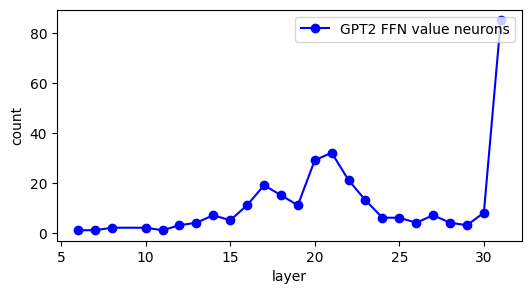

In [11]:
#visualize the number of value FFN neurons in different layers
FFN_value_neurons = [x[0] for x in ffn_subvalue_list_sort[:300]]
FFN_layer_count_value = [int(x.split("_")[0]) for x in list(FFN_value_neurons)]
FFN_layer_count_value = Counter(FFN_layer_count_value)
FFN_layer_count_value = sorted(zip(FFN_layer_count_value.keys(), FFN_layer_count_value.values()))
gpt_FFN_value_x, gpt_FFN_value_y = transfer_l(FFN_layer_count_value)

plt.figure(figsize=(6,3))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(gpt_FFN_value_x, gpt_FFN_value_y, "bo-", label="GPT2 FFN value neurons")
plt.xlabel("layer", fontsize=10)
plt.ylabel("count", fontsize=10)
plt.legend(fontsize=10, loc="upper right")
plt.show()

In [12]:
#attn neuron increase (value attention neuron)
cur_file_attn_neuron_list = []
for test_layer in range(LAYER_NUM):
    cur_layer_input = torch.tensor(all_pos_layer_input[test_layer])
    cur_v_heads_recompute = torch.tensor(all_last_attn_subvalues[test_layer]).permute(1, 0, 2)
    cur_attn_o_split = model.model.layers[test_layer].self_attn.o_proj.weight.data.T.view(HEAD_NUM, HEAD_DIM, -1)
    cur_attn_o_recompute = cur_attn_o_split * cur_v_heads_recompute.unsqueeze(-1)
    cur_layer_input_last = cur_layer_input[-1]
    origin_prob = torch.log(get_prob(get_bsvalues(cur_layer_input_last, model, final_var))[predict_index])
    cur_attn_o_head_plus = cur_attn_o_recompute + cur_layer_input_last
    cur_attn_plus_probs = torch.log(get_prob(get_bsvalues(
        cur_attn_o_head_plus, model, final_var))[:, :, :, predict_index])
    cur_attn_plus_probs_increase = cur_attn_plus_probs - origin_prob
    for pos_index in range(cur_attn_plus_probs_increase.size(0)):
        for head_index in range(cur_attn_plus_probs_increase.size(1)):
            for attn_neuron_index in range(cur_attn_plus_probs_increase.size(2)):
                cur_file_attn_neuron_list.append((str(test_layer)+"_"+str(head_index)+"_"+str(
                    attn_neuron_index)+"_"+str(pos_index), 
                    cur_attn_plus_probs_increase[pos_index][head_index][attn_neuron_index].item()))
cur_file_attn_neuron_list_sort = sorted(cur_file_attn_neuron_list, key=lambda x: x[-1])[::-1]
print(list(zip(range(len(tokens)), tokens)))
for x in cur_file_attn_neuron_list_sort[:50]:
    layer_i, head_i, neuron_i, _ = x[0].split("_") #layer_head_neuron_pos
    layer_i, head_i, neuron_i = int(layer_i), int(head_i), int(neuron_i)
    cur_neuron = model.model.layers[layer_i].self_attn.o_proj.weight.data.T.view(HEAD_NUM, HEAD_DIM, -1)[head_i][neuron_i]
    cur_neuron_bsvalue = get_bsvalues(cur_neuron, model, final_var)
    cur_neuron_bsvalue_sort = torch.argsort(cur_neuron_bsvalue, descending=True)
    print(x[0], round(x[1], 4), "top10: ", [tokenizer.decode(a) for a in cur_neuron_bsvalue_sort[:10]])
    print(x[0], round(x[1], 4), "last10: ", [tokenizer.decode(a) for a in cur_neuron_bsvalue_sort[-10:].tolist()[::-1]])

[(0, '<s>'), (1, 'Tim'), (2, 'Dun'), (3, 'can'), (4, 'plays'), (5, 'the'), (6, 'sport'), (7, 'of')]
21_0_79_3 0.0433 top10:  ['invent', 'ship', 'ventory', 'boat', 'Task', 'shop', 'ships', 'Bom', 'Task', 'boats']
21_0_79_3 0.0433 last10:  ['training', 'shared', 'Training', 'training', 'Shared', 'Shared', 'shared', 'share', 'driving', 'train']
21_0_64_3 0.0405 top10:  ['tax', 'Tax', 'tax', 'shoot', 'Test', 'destruction', 'destroyed', 'tests', 'test', 'Tests']
21_0_64_3 0.0405 last10:  ['Support', 'support', 'Support', 'support', 'supports', 'supported', 'supporting', 'supported', 'traffic', '支']
18_23_79_3 0.0366 top10:  ['z', 'Masters', 'Master', 'zk', 'Master', 'Dr', 'master', 'z', 'Chinese', 'master']
18_23_79_3 0.0366 last10:  ['Islam', 'Muslim', 'biz', 'Catholic', 'jazz', 'Lib', 'PH', 'Basketball', 'Phili', 'nah']
18_23_64_3 0.0354 top10:  ['KEY', 'keys', 'Key', 'Kevin', 'key', 'X', 'key', 'KEY', 'z', 'xs']
18_23_64_3 0.0354 last10:  ['Mac', 'MAC', 'Mac', 'Мак', 'Ph', 'Beng', 'Dr', 

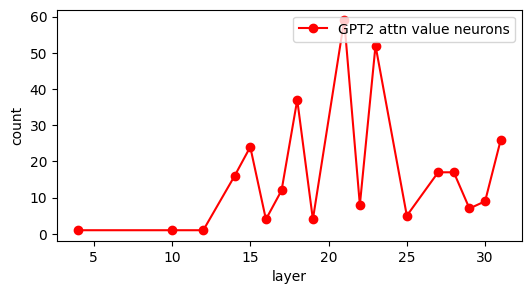

In [13]:
#visualize the number of value attention neurons in different layers
attn_value_neurons = [x[0] for x in cur_file_attn_neuron_list_sort[:300]]
attn_layer_count_value = [int(x.split("_")[0]) for x in list(attn_value_neurons)]
attn_layer_count_value = Counter(attn_layer_count_value)
attn_layer_count_value = sorted(zip(attn_layer_count_value.keys(), attn_layer_count_value.values()))
gpt_attn_value_x, gpt_attn_value_y = transfer_l(attn_layer_count_value)

plt.figure(figsize=(6,3))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(gpt_attn_value_x, gpt_attn_value_y, "ro-", label="GPT2 attn value neurons")
plt.xlabel("layer", fontsize=10)
plt.ylabel("count", fontsize=10)
plt.legend(fontsize=10, loc="upper right")
plt.show()

[(30.5, 0.383), (17.5, 0.362), (31.0, 0.3108), (20.5, 0.2759), (15.0, 0.2412), (22.5, 0.2263), (24.5, 0.2119), (18.0, 0.2099), (18.5, 0.2055), (21.5, 0.1852), (14.0, 0.1782), (21.0, 0.1658), (17.0, 0.1511), (16.5, 0.1437), (15.5, 0.1335), (19.5, 0.1119), (14.5, 0.1055), (23.0, 0.0963), (28.5, 0.0914), (12.0, 0.0834), (10.0, 0.0829), (13.5, 0.0819), (9.5, 0.0814), (8.5, 0.0749), (19.0, 0.067), (26.0, 0.0618), (22.0, 0.0558), (25.0, 0.0529), (6.0, 0.0478), (29.5, 0.0424), (11.0, 0.0423), (26.5, 0.0376), (8.0, 0.0368), (4.0, 0.0309), (5.0, 0.0274), (9.0, 0.027), (2.0, 0.0255), (28.0, 0.0233), (30.0, 0.0216), (11.5, 0.0092), (1.0, 0.0087), (20.0, 0.0082), (4.5, 0.0054), (0.0, 0.0049), (13.0, 0.0016), (10.5, 0.0015), (12.5, 0.0008), (27.5, 0.0002), (31.5, 0.0), (1.5, -0.0055), (-0.5, -0.01), (3.0, -0.0101), (7.5, -0.0105), (7.0, -0.0131), (5.5, -0.0172), (0.5, -0.018), (23.5, -0.0198), (3.5, -0.0203), (6.5, -0.0241), (2.5, -0.0261), (24.0, -0.0442), (16.0, -0.0505), (27.0, -0.0552), (29.0, 

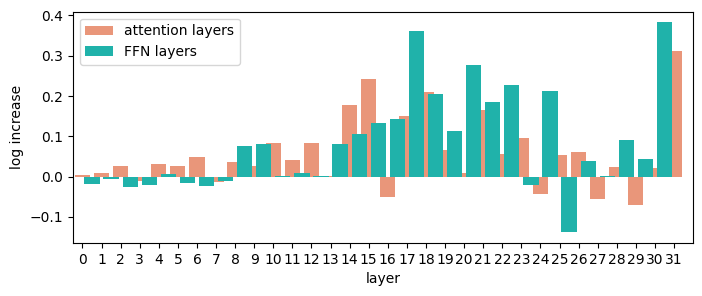

In [14]:
#find query layers activating FFN neurons
all_residual_scores = [0.0]*(1+2*LAYER_NUM)
for l_n, increase_score in ffn_subvalue_list_sort[:30]:
    ffn_layer, ffn_neuron = l_n.split("_")
    ffn_layer, ffn_neuron = int(ffn_layer), int(ffn_neuron)
    ffn_neuron_key = model.model.layers[ffn_layer].mlp.down_proj.weight.data[:, ffn_neuron]
    ffn_neuron_key_new = ffn_neuron_key * model.model.layers[ffn_layer].post_attention_layernorm.weight.data
    last_layer_residualstream = [torch.tensor(all_pos_layer_input[0][-1]).unsqueeze(0)]
    for layer_i in range(ffn_layer):
        last_layer_residualstream.append(torch.tensor(all_pos_attn_output[layer_i][-1]).unsqueeze(0))
        last_layer_residualstream.append(torch.tensor(all_pos_ffn_output[layer_i][-1]).unsqueeze(0))
    last_layer_residualstream.append(torch.tensor(all_pos_attn_output[ffn_layer][-1]).unsqueeze(0))
    last_layer_residualstream_cat = torch.cat(last_layer_residualstream, 0)
    last_layer_residualstream_innerproduct = torch.sum(last_layer_residualstream_cat*ffn_neuron_key_new, -1)
    last_layer_residualstream_innerproduct_zip = list(zip(range(len(last_layer_residualstream_innerproduct)), last_layer_residualstream_innerproduct.tolist()))
    sum_inner_product = sum([x[1] for x in last_layer_residualstream_innerproduct_zip])
    for l, inner in last_layer_residualstream_innerproduct_zip:
        all_residual_scores[l] += inner/sum_inner_product * increase_score
all_residual_scores_zip = list(zip(range(len(all_residual_scores)), all_residual_scores))
all_residual_scores_zip_sort = sorted(all_residual_scores_zip, key=lambda x: x[-1])[::-1]
print([(a[0]/2-0.5, round(a[1],4)) for a in all_residual_scores_zip_sort])
plt_bar(range(len(all_residual_scores[1:])), all_residual_scores[1:])

avg attn layer:  20.366666666666667
[(19.5, 0.08639770441801671), (20.5, 0.06275743732671873), (15.5, 0.05846005433555804), (10.5, 0.04773598417795908), (8.5, 0.04495325701852381), (5.5, 0.04238332015045458), (16.0, 0.040279350790582556), (17.5, 0.033828808444500744), (12.5, 0.03358343324720928), (15.0, 0.03318174810684847)]


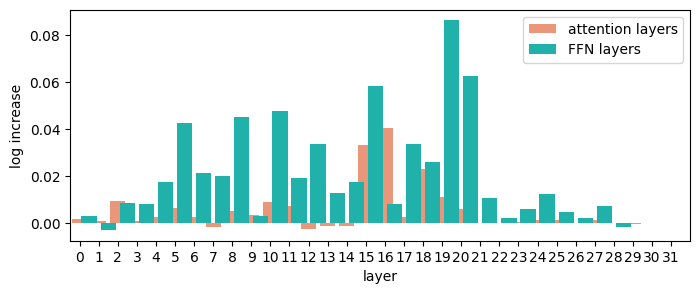

In [15]:
#find query layers activating attn neurons
all_residual_scores = [0.0]*(1+2*LAYER_NUM)
avg_attn_layer_curdir = []
for l_h_n_p, increase_score in cur_file_attn_neuron_list_sort[:30]:
    attn_layer, attn_head, attn_neuron, attn_pos = l_h_n_p.split("_")
    attn_layer, attn_head, attn_neuron, attn_pos = int(attn_layer), int(attn_head), int(attn_neuron), int(attn_pos)
    avg_attn_layer_curdir.append(attn_layer)
    cur_attn_neuron = attn_head*HEAD_DIM+attn_neuron
    attn_neuron_key = model.model.layers[attn_layer].self_attn.v_proj.weight.data[cur_attn_neuron]
    attn_neuron_key_new = attn_neuron_key * model.model.layers[attn_layer].input_layernorm.weight.data
    pos_layer_residualstream = [torch.tensor(all_pos_layer_input[0][attn_pos]).unsqueeze(0)]
    for layer_i in range(attn_layer):
        pos_layer_residualstream.append(torch.tensor(all_pos_attn_output[layer_i][attn_pos]).unsqueeze(0))
        pos_layer_residualstream.append(torch.tensor(all_pos_ffn_output[layer_i][attn_pos]).unsqueeze(0))
    pos_layer_residualstream_cat = torch.cat(pos_layer_residualstream, 0)
    pos_layer_residualstream_innerproduct = torch.sum(pos_layer_residualstream_cat*attn_neuron_key_new, -1)
    pos_layer_residualstream_innerproduct_zip = list(zip(range(len(pos_layer_residualstream_innerproduct)), pos_layer_residualstream_innerproduct.tolist()))
    sum_inner_product = sum([x[1] for x in pos_layer_residualstream_innerproduct_zip])
    for l, inner in pos_layer_residualstream_innerproduct_zip:
        all_residual_scores[l] += inner/sum_inner_product * increase_score
all_residual_scores_zip = list(zip(range(len(all_residual_scores)), all_residual_scores))
all_residual_scores_zip_sort = sorted(all_residual_scores_zip, key=lambda x: x[-1])[::-1]
print("avg attn layer: ", sum(avg_attn_layer_curdir)/len(avg_attn_layer_curdir))
print([(a[0]/2-0.5, a[1]) for a in all_residual_scores_zip_sort[:10]])
plt_bar(range(len(all_residual_scores[1:])), all_residual_scores[1:])

In [16]:
#find query FFN neurons activating attn neurons
curfile_ffn_score_dict = {}
for l_h_n_p, increase_score in cur_file_attn_neuron_list_sort[:30]:
    attn_layer, attn_head, attn_neuron, attn_pos = l_h_n_p.split("_")
    attn_layer, attn_head, attn_neuron, attn_pos = int(attn_layer), int(attn_head), int(attn_neuron), int(attn_pos)
    cur_attn_neuron = attn_head*HEAD_DIM+attn_neuron
    attn_neuron_key = model.model.layers[attn_layer].self_attn.v_proj.weight.data[ cur_attn_neuron]
    attn_neuron_key_new = attn_neuron_key * model.model.layers[attn_layer].input_layernorm.weight.data
    cur_inner_all = torch.sum(torch.tensor(all_pos_layer_input[attn_layer][attn_pos])*attn_neuron_key_new, -1)
    for layer_i in range(attn_layer):
        cur_layer_neurons = (torch.tensor(all_pos_coefficient_scores[layer_i][attn_pos])*get_fc2_params(model, layer_i)).T
        cur_layer_neurons_innerproduct = torch.sum(cur_layer_neurons * attn_neuron_key_new, -1)/cur_inner_all
        for neuron_i in range(len(cur_layer_neurons_innerproduct)):
            if str(layer_i)+"_"+str(neuron_i) not in curfile_ffn_score_dict:
                curfile_ffn_score_dict[str(layer_i)+"_"+str(neuron_i)] = 0.0
            curfile_ffn_score_dict[str(layer_i)+"_"+str(neuron_i)] += cur_layer_neurons_innerproduct[neuron_i].item() * increase_score

In [17]:
#projecting the query FFN neurons into unembedding space: shallow neurons are not usually interpretable (e.g. 5_5005)
cur_file_neurons_ffn_zip = list(zip(curfile_ffn_score_dict.keys(), curfile_ffn_score_dict.values()))
cur_file_neurons_ffn_zip_sort = sorted(cur_file_neurons_ffn_zip, key=lambda x: x[-1])[::-1]
for x in cur_file_neurons_ffn_zip_sort[:10]:
    print(x[0], round(x[1], 4))
    layer = int(x[0].split("_")[0])
    neuron = int(x[0].split("_")[1])
    cur_vector = get_fc2_params(model, layer).T[neuron]
    cur_vector_bsvalue = get_bsvalues(cur_vector, model, final_var)
    cur_vector_bsvalue_sort = torch.argsort(cur_vector_bsvalue, descending=True)
    print("top10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[:10]])
    print("last10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[-10:].tolist()[::-1]])

19_3291 0.0675
top10:  ['guard', 'basket', 'fou', 'rim', 'court', 'ho', 'guard', 'NBA', 'Basketball', 'basketball']
last10:  ['hockey', 'Hockey', 'AML', 'ML', 'Major', 'Racing', 'baseball', 'ugno', 'manager', '<0x8C>']
10_8021 0.0318
top10:  ['NBA', 'sime', 'court', 'Ἐ', 'vod', 'Zygote', 'Point', 'mv', 'hardware', 'ząt']
last10:  ['agen', 'Soccer', 'Wrestling', 'Football', 'Meyer', 'cu', 'FC', 'Lam', 'football', 'aban']
17_5502 0.0249
top10:  ['NBA', 'court', 'court', 'basket', 'shooting', 'Basketball', 'guard', 'icha', 'floor', 'basketball']
last10:  ['football', 'Football', 'football', 'NFL', 'футбо', 'quarter', 'Foot', 'Kol', 'receiver', 'baseball']
15_1837 0.0194
top10:  ['floor', 'NBA', 'court', 'court', 'basket', 'courts', 'basketball', 'floor', 'Basketball', 'ho']
last10:  ['Football', 'football', 'football', 'футбо', 'Driver', 'apps', 'yg', 'Foot', 'Fußball', 'yard']
8_2689 0.0192
top10:  ['rim', 'shell', 'ič', 'anter', 'urn', 'orders', 'iből', '子', '<0xC4>', 'fou']
last10:  ['

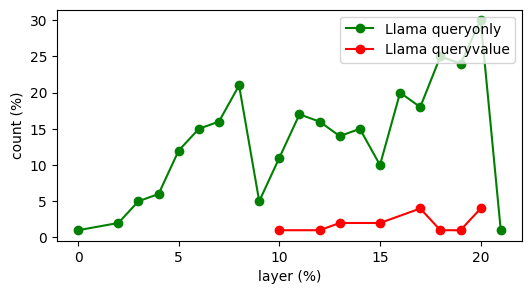

In [18]:
#visualize the queryonly and queryvalue neurons
value_neurons = [x[0] for x in ffn_subvalue_list_sort[:300]]
query_neurons = [x[0] for x in cur_file_neurons_ffn_zip_sort[:300]]
queryvalue_neurons = set(value_neurons) & set(query_neurons)
queryonly_neurons = set(query_neurons) - queryvalue_neurons
layer_count_queryonly = [int(x.split("_")[0]) for x in list(queryonly_neurons)]
layer_count_queryonly = Counter(layer_count_queryonly)
layer_count_queryonly = sorted(zip(layer_count_queryonly.keys(), layer_count_queryonly.values()))
gpt_queryonly_x, gpt_queryonly_y = transfer_l(layer_count_queryonly)
layer_count_queryvalue = [int(x.split("_")[0]) for x in list(queryvalue_neurons)]
layer_count_queryvalue = Counter(layer_count_queryvalue)
layer_count_queryvalue = sorted(zip(layer_count_queryvalue.keys(), layer_count_queryvalue.values()))
gpt_queryvalue_x, gpt_queryvalue_y = transfer_l(layer_count_queryvalue)

plt.figure(figsize=(6,3))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(gpt_queryonly_x, gpt_queryonly_y, "go-", label="Llama queryonly")
plt.plot(gpt_queryvalue_x, gpt_queryvalue_y, "ro-", label="Llama queryvalue")
plt.xlabel("layer (%)", fontsize=10)
plt.ylabel("count (%)", fontsize=10)
plt.legend(fontsize=10, loc="upper right")
plt.show()

In [19]:
#find an attention neuron's query FFN neurons
curfile_ffn_score_dict = {}
l_h_n_p = "15_15_112_3"
attn_layer, attn_head, attn_neuron, attn_pos = l_h_n_p.split("_")
attn_layer, attn_head, attn_neuron, attn_pos = int(attn_layer), int(attn_head), int(attn_neuron), int(attn_pos)
cur_attn_neuron = attn_head*HEAD_DIM+attn_neuron
attn_neuron_key = model.model.layers[attn_layer].self_attn.v_proj.weight.data[cur_attn_neuron]
attn_neuron_key_new = attn_neuron_key * model.model.layers[attn_layer].input_layernorm.weight.data
cur_inner_all = torch.sum(torch.tensor(all_pos_layer_input[attn_layer][attn_pos])*attn_neuron_key_new, -1)
for layer_i in range(attn_layer):
    cur_layer_neurons = (torch.tensor(all_pos_coefficient_scores[layer_i][attn_pos])*get_fc2_params(model, layer_i)).T
    cur_layer_neurons_innerproduct = torch.sum(cur_layer_neurons * attn_neuron_key_new, -1)/cur_inner_all
    for neuron_i in range(len(cur_layer_neurons_innerproduct)):
        if str(layer_i)+"_"+str(neuron_i) not in curfile_ffn_score_dict:
            curfile_ffn_score_dict[str(layer_i)+"_"+str(neuron_i)] = 0.0
        curfile_ffn_score_dict[str(layer_i)+"_"+str(neuron_i)] += cur_layer_neurons_innerproduct[neuron_i].item() * increase_score
cur_file_neurons_ffn_zip = list(zip(curfile_ffn_score_dict.keys(), curfile_ffn_score_dict.values()))
cur_file_neurons_ffn_zip_sort = sorted(cur_file_neurons_ffn_zip, key=lambda x: x[-1])[::-1]
print([x[0] for x in cur_file_neurons_ffn_zip_sort[:10]])
for x in cur_file_neurons_ffn_zip_sort[:10]:
    print(x[0], round(x[1], 4))
    layer = int(x[0].split("_")[0])
    neuron = int(x[0].split("_")[1])
    cur_vector = get_fc2_params(model, layer).T[neuron]
    cur_vector_bsvalue = get_bsvalues(cur_vector, model, final_var)
    cur_vector_bsvalue_sort = torch.argsort(cur_vector_bsvalue, descending=True)
    print("top10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[:10]])
    print("last10: ", [tokenizer.decode(a) for a in cur_vector_bsvalue_sort[-10:].tolist()[::-1]])

['10_8021', '7_4316', '5_5005', '6_8735', '8_2689', '5_521', '7_10096', '4_5374', '2_9024', '10_7501']
10_8021 0.0016
top10:  ['NBA', 'sime', 'court', 'Ἐ', 'vod', 'Zygote', 'Point', 'mv', 'hardware', 'ząt']
last10:  ['agen', 'Soccer', 'Wrestling', 'Football', 'Meyer', 'cu', 'FC', 'Lam', 'football', 'aban']
7_4316 0.0016
top10:  ['<0x97>', 'niej', 'fø', 'mannschaft', 'CF', '위', '<0x0C>', 'Johnny', 'Jersey', 'cn']
last10:  ['Tennis', 'лан', 'Athlet', 'tennis', '民', 'wire', 'init', '.:\u200a', 'ъ', 'HMS']
5_5005 0.0012
top10:  ['experimental', 'ios', 'eni', 'Edu', 'Mil', 'magn', 'Edit', 'ears', '<0x8F>', 'оз']
last10:  ['rane', 'rain', 'orno', 'TAG', 'urm', 'sign', 'atia', 'град', 'orrow', 'ractor']
6_8735 0.0011
top10:  ['ляр', 'punkt', 'wise', 'edad', 'iani', 'Terminal', 'ļ', 'appen', 'ores', 'coh']
last10:  ['dro', 'lock', 'ogle', 'mu', 'mag', 'esta', 'ku', 'cito', 'unnel', 'cloudflare']
8_2689 0.0011
top10:  ['rim', 'shell', 'ič', 'anter', 'urn', 'orders', 'iből', '子', '<0xC4>', 'fou'

In [20]:
#A hidden-interpretable shallow FFN neuron becomes interpretable after transformation by attention heads.
#please see this paper for details: https://arxiv.org/pdf/2409.14144
test_query_neuron = "5_5005"
test_query_layer, test_query_index = test_query_neuron.split("_")
test_query_layer, test_query_index = int(test_query_layer), int(test_query_index)
cur_neuron_vector = get_fc2_params(model, test_query_layer)[:, test_query_index]
cur_neuron_vector_ln = model.model.layers[attn_layer].input_layernorm(cur_neuron_vector)
cur_neuron_v = model.model.layers[attn_layer].self_attn.v_proj(
    cur_neuron_vector_ln)[attn_head*HEAD_DIM:attn_head*HEAD_DIM+HEAD_DIM]
cur_attn_o_split = model.model.layers[attn_layer].self_attn.o_proj.weight.data.T.view(
    HEAD_NUM, HEAD_DIM, -1)[attn_head]
cur_neuron_vo = torch.sum(cur_neuron_v.unsqueeze(1)*cur_attn_o_split, 0)
cur_neuron_o_bsvalues = get_bsvalues(cur_neuron_vo, model, final_var)
cur_neuron_o_bsvalues_sort = torch.argsort(cur_neuron_o_bsvalues, descending=True)
print("top: ", [tokenizer.decode(x) for x in cur_neuron_o_bsvalues_sort[:10]])
print("last: ", [tokenizer.decode(x) for x in cur_neuron_o_bsvalues_sort[-10:].tolist()[::-1]])

top:  ['dock', 'Football', 'Racing', 'football', 'football', 'fish', 'NAS', 'emet', 'racing', 'sail']
last:  ['basketball', 'Basketball', 'NBA', 'Jazz', 'asketball', 'jazz', 'Bird', 'basket', 'court', 'courts']
